In [119]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import torch.utils.data as Data
from random import shuffle

In [120]:
X, y = load_digits(return_X_y=True)
 # X.shape:(1797, 64)
 # y.shape:(1797,)
 # type : <class 'numpy.ndarray'>
X = [x.reshape([1, 8, 8]).tolist() for x in X]
# 原数据可能会把相近的类别放在一起，所以分割数据前最好要打乱
choose_index = np.arange(1797)
shuffle(choose_index)

 # 转换成tensor
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.int64)

 # 将数据和标签整合在一起
train_data = Data.TensorDataset(X_t[choose_index[:1300]], y_t[choose_index[:1300]])
test_data = Data.TensorDataset(X_t[choose_index[1300:]], y_t[choose_index[1300:]])

 # 构建数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = Data.DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=True,
    num_workers=0
)


In [121]:
# 定义网络
class CNNClassifier(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(CNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),               # [B, 16, 8, 8]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),    # [B, 32, 4, 4]
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, 2, 1),    # [B, 16, 2, 2]
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, 1, 1)       # [B, 8, 2, 2]
        )
        self.output = nn.Linear(32, 10)
    def forward(self, x):
        out = self.conv(x)
         # out : [B, 8, 2, 2]
        out = self.output(out.flatten(start_dim=1))
        out = nn.functional.softmax(out, dim=1)
        return out


In [122]:
net = CNNClassifier(input_channels=1, output_dim=10)

In [123]:
 # 网络实例化
#net = LinearLayerClassifier(input_dim=64, output_dim=10)
 # 获取优化器
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
 # 获取损失函数
loss_func = nn.CrossEntropyLoss(reduction="mean")
 # 记录损失
train_loss, train_acc = [], []
test_loss, test_acc = [], []

[0.7661033163265306, 0.8577407525510203, 0.9116709183673469, 0.9475845025510203, 0.9577885841836735, 0.9630500637755102, 0.8696189413265306, 0.9583864795918368, 0.9143813775510203, 0.9636479591836735, 0.9118303571428572, 0.9486208545918368, 0.9456313775510203, 0.9591438137755102, 0.9585459183673469, 0.9610969387755102, 0.9689094387755102, 0.9190449617346939, 0.9753667091836735, 0.970703125, 0.9765625, 0.9753667091836735, 0.9759646045918368, 0.9779177295918368, 0.9779177295918368, 0.9759646045918368, 0.9741709183673469, 0.9765625, 0.978515625, 0.9798708545918368, 0.9681521045918368, 0.9474250637755102, 0.9779177295918368, 0.984375, 0.9779177295918368, 0.9818239795918368, 0.9831792091836735, 0.984375, 0.9857302295918368, 0.984375]


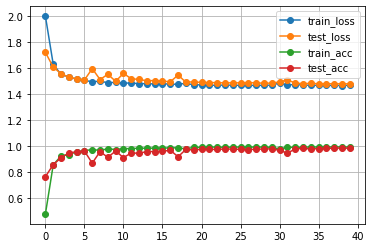

In [124]:
# 开始训练
for epoch in range(40):
     # 遍历生成器
    net.train()
    epoch_loss, epoch_acc = [], []  # 记录当前epoch的loss和accuracy
    for batch in train_loader:
        data, label = batch
         # 前向传播
        output = net(data)
         # 预测标签
        predict_label = torch.argmax(output, dim=1)
         # 计算损失
        loss = loss_func(output, label)
         # 梯度清空
        optimizer.zero_grad()
         # 反向传播
        loss.backward()
         # 更新参数
        optimizer.step()

         # 记录训练结果
        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy_score(predict_label, label))

    train_loss.append(np.mean(epoch_loss))
    train_acc.append(np.mean(epoch_acc))

     # 遍历测试集
    net.eval()
    epoch_loss, epoch_acc = [], []
    for batch in test_loader:
        data, label = batch
        output = net(data)
        predict_label = torch.argmax(output, dim=1)
        loss = loss_func(output, label)
        epoch_loss.append(loss.item())
        epoch_acc.append(accuracy_score(predict_label, label))

    test_loss.append(np.mean(epoch_loss))
    test_acc.append(np.mean(epoch_acc))

 # 可视化数据
print(test_acc)
label_name = ["train_loss", "test_loss", "train_acc", "test_acc"]
for index, name in enumerate([train_loss, test_loss, train_acc, test_acc]):
    plt.plot(name, "o-", label=label_name[index])

plt.legend()
plt.grid(True)
plt.show()
